# Calcul du flux à la ligne d'échouage sur tout l'Antactique

calcul avec les code de Cyrille Mosdeux avec une modification pour la sauvegarde en fichier netCDF et l'utilisation d'une librairie locale pour faire le calcul final de flux sur la région d'Amundsen.

In [23]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from skimage import measure
import config
import importlib
import sys

# === Load personal function ===
sys.path.append(f'{config.SAVE_PATH}/Function')
import Function.ISMIP_function as ismip

In [24]:
# === Local Functions ===
def resample_line(x, y, spacing):
    dists = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
    dist_cum = np.concatenate([[0], np.cumsum(dists)])
    n_points = int(dist_cum[-1] // spacing)
    new_distances = np.linspace(0, dist_cum[-1], n_points)
    x_new = np.interp(new_distances, dist_cum, x)
    y_new = np.interp(new_distances, dist_cum, y)
    return x_new, y_new

def interp_field(field, x_gl, y_gl, method='linear'):
    if type(field) is xr.DataArray:
        interp = RegularGridInterpolator((y, x), field.values, bounds_error=False, fill_value=np.nan, method=method)
    else:
        interp = RegularGridInterpolator((y, x), field, bounds_error=False, fill_value=np.nan, method=method)
    return interp(np.column_stack((y_gl, x_gl)))

def check_neighbors(grounded_mask, x_gl, y_gl, resolution):
    close_to_real_gl = []
    for xi, yi in zip(x_gl, y_gl):
        check = (interp_field(grounded_mask, xi, yi, method='nearest') +
                 interp_field(grounded_mask, xi + resolution, yi, method='nearest') +
                 interp_field(grounded_mask, xi - resolution, yi, method='nearest') +
                 interp_field(grounded_mask, xi, yi + resolution, method='nearest') +
                 interp_field(grounded_mask, xi, yi - resolution, method='nearest'))
        close_to_real_gl.append(check < 5)
    return np.array(close_to_real_gl)

In [25]:
# === Parameters ===
grounding_line_level = 0.0
density_ice = 917  # kg/m^3
resample_spacing = 1000
max_velocity_threshold = 2000 #np.inf #or np.Inf depending on python version

In [26]:
# === Load and mask data ===
bed = xr.open_dataset(f'{config.SAVE_PATH}/Result/BedMachine.nc').bed
bed = ismip.grid_4x4(bed)
surface = xr.open_dataset(f'{config.SAVE_PATH}/Result/BedMachine.nc').surface
surface = ismip.grid_4x4(surface)
thickness = xr.open_dataset(f'{config.SAVE_PATH}/Result/BedMachine.nc').thickness
thickness = ismip.grid_4x4(thickness)
vx = xr.open_dataset(f'{config.SAVE_PATH}/Result/antarctica_velocity_updated_v2.nc').vx
vx = ismip.grid_4x4(vx)
vy = xr.open_dataset(f'{config.SAVE_PATH}/Result/antarctica_velocity_updated_v2.nc').vy
vy = ismip.grid_4x4(vy)

In [27]:
ice_base = (surface - thickness)
grounded_mask = np.abs(ice_base - bed).values < 1e-2  # Boolean grounded mask

In [28]:
# Coordinates
x = bed["x"].values
y = bed["y"].values

In [29]:
gl_mask = grounded_mask.astype(float)

In [30]:
# Find contours at the 0.5 level = boundary between grounded (1) and ungrounded (0)
contours = measure.find_contours(grounded_mask, level=0.5)

if not contours:
    raise RuntimeError("No contour found at level 0.5 — check your data.")
contour = max(contours, key=len)
contour_y, contour_x = contour.T  # in pixel coords

In [31]:
# Convert to real-world coordinates
dx = x[1] - x[0]
dy = y[1] - y[0]
x_real = x[0] + contour_x * dx
y_real = y[0] + contour_y * dy

In [32]:
x_gl, y_gl = resample_line(x_real, y_real, resample_spacing)
print(f'x_gl: {x_gl.shape}, y_gl: {y_gl.shape}')

x_gl: (41957,), y_gl: (41957,)


In [33]:
vx_gl = interp_field(vx, x_gl, y_gl)
vy_gl = interp_field(vy, x_gl, y_gl)
H_gl = interp_field(thickness, x_gl, y_gl)

In [34]:
# Check if the GL points are close to a real grounded line (on the mesh)
gl_check_status = check_neighbors(grounded_mask, x_gl, y_gl, dx)

In [35]:
# === Compute Local Normals ===
dx = np.gradient(x_gl)
dy = np.gradient(y_gl)
dl = np.sqrt(dx**2 + dy**2)
nx = dy / dl
ny = -dx / dl

In [36]:
# === Project Velocities onto Normals ===
vn = vx_gl * nx + vy_gl * ny
#vn =vn * 365.25 * 24 * 3600  # Convert to m/yr
vn[np.isnan(vn)] = 0
vn[vn > max_velocity_threshold] = 0.1

In [37]:
# === Compute Segmental Flux ===
flux = H_gl * vn * dl

In [38]:
# In case of masking of a region, mask boundaries should be removed from the flux computation 
# since they are not real grounded lines
#flux[gl_check_status == False] = 0  # Set flux to 0 for points not close to a real grounded line 
flux[np.isnan(flux)] = 0  #remove possible NaN values 
total_flux_kg_per_yr = np.sum(flux) * density_ice
total_flux_Gt_per_yr = total_flux_kg_per_yr / 1e12

In [39]:
mass_flux = flux / dl / 1e6 # Gt/yr

mass_flux[mass_flux == 0] = np.nan

Total integrated flux through grounding line: 1426.14 Gt/yr
(np.float64(-3040000.0), np.float64(3040000.0), np.float64(-3040000.0), np.float64(3040000.0))


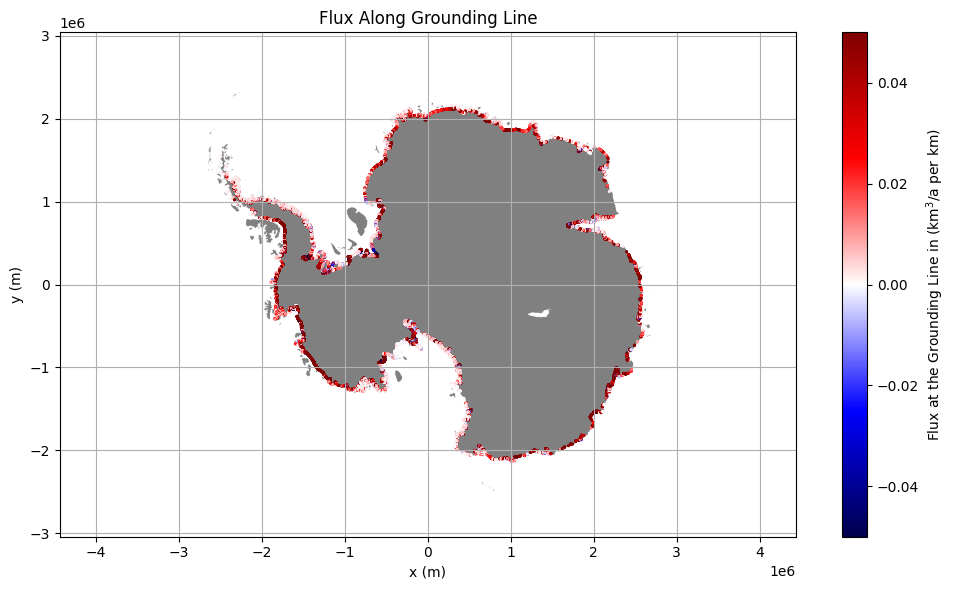

In [40]:
# === Output ===
print(f"Total integrated flux through grounding line: {total_flux_Gt_per_yr:.2f} Gt/yr")

# === Optional: Plot ===
plt.figure(figsize=(10, 6))
plt.title("Flux Along Grounding Line")
print((x[0], x[-1], y[0], y[-1]))
plt.imshow(grounded_mask, cmap="Greys", vmin = 0, vmax = 1 ,origin="lower", extent=(x[0], x[-1], y[0], y[-1]), alpha=0.5,zorder=-1)
plt.scatter(x_gl, y_gl, c=mass_flux,vmin = -0.05, vmax = 0.05, cmap="seismic", s=1)
plt.colorbar(label=r"Flux at the Grounding Line in (km$^3$/a per km)")
plt.axis("equal")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.grid(True)
plt.tight_layout()

In [41]:
flux_total = xr.zeros_like(bed)
flux_total.attrs.update({
    'units': 'Gt yr⁻¹',
    'long_name': 'Ice flux at the grounding line',
    'standard_name': 'grounding_line_flux'
})
flux_ds = xr.Dataset({'ligroundf': flux_total})

In [42]:
for i, (x_line, y_line) in enumerate(zip(x_gl, y_gl)):
    selected_point = flux_ds.ligroundf.sel(x=x_line, y=y_line, method='nearest')
    x_idx, y_idx = selected_point.x.values, selected_point.y.values
    flux_ds.ligroundf.loc[dict(x=x_idx, y=y_idx)] += flux[i]

# === Save and plot ===
nc_path = f'{config.SAVE_PATH}/Result/ligroundf_bedmachine_all_ant_w_thres.nc'
flux_ds.to_netcdf(nc_path)

In [43]:
test_flux_ds = xr.open_dataset(nc_path)

In [44]:
flux_amun_test = ismip.basin_flux_hand(test_flux_ds.ligroundf, 'Amundsen')
print(f"Amundsen Basin flux: {flux_amun_test:.2f} Gt/yr")

Amundsen Basin flux: 187.81 Gt/yr
